In [12]:
import scqubits as scqubits
import numpy as np
import scipy as sci
from system import SNAIL, calculate_overlap
import qutip as qt

class Hamiltonian:
    def __init__(self, phi_ex, Ej, Ec, dim):
        self.phi_ex = phi_ex
        self.Ej = Ej * 2*np.pi
        self.Ec = Ec * 2*np.pi
        self.beta = 1
        self.N = 1
        self.dim = np.array(dim)
        self.total_dim = np.prod(dim)
        self.sdim = 10
        self.cdim = 6
        self.epsilon =1e-6
        self.get_H()
        self.get_H_der()
     
    def annihilation(self, dim):
        return np.diag(np.sqrt(np.arange(1,dim)),1)
    def creation(self, dim):
        return np.diag(np.sqrt(np.arange(1,dim)),-1)
    

    def sort_eigenpairs(self, eigenvalues, eigenvectors):
        n = eigenvectors.shape[0]
        sorted_indices = []

        for i in range(n):
            max_abs_vals = np.abs(eigenvectors[i, :])
            max_index = np.argmax(max_abs_vals)
            while max_index in sorted_indices:
                max_abs_vals[max_index] = -np.inf
                max_index = np.argmax(max_abs_vals)
            sorted_indices.append(max_index)

        sorted_eigenvalues = eigenvalues[sorted_indices]
        sorted_eigenvectors = eigenvectors[:, sorted_indices]
        return sorted_eigenvalues, sorted_eigenvectors
    
    def tensor_product(self,A,B,C):
        return np.kron(A,np.kron(B,C))
    
    def composite_sys(self, squid,cavity, cavity2,  ):
        Hs, charge_op = squid
        Hc, Vc = cavity
        Hc2, Vc2 = cavity2
        sdim = Hs.shape[0]
        cdim = Hc.shape[0]
        cdim2 = Hc2.shape[0]
        Ic = np.identity(cdim)
        Ic2 = np.identity(cdim2)
        Is = np.identity(sdim)
        Hs = self.tensor_product(Hs,Ic,Ic2)
        Hc = self.tensor_product(Is, Hc, Ic2)
        Hc2 = self.tensor_product(Is, Ic, Hc2)
        H_int = 0.05*2*np.pi * self.tensor_product(charge_op, Vc, Ic2) 
        H_int2 = 0.05*2*np.pi * self.tensor_product(charge_op, Ic, Vc2) 
        H = Hs + Hc + Hc2 + H_int + H_int2
        H_control = self.tensor_product(charge_op, Ic, Ic2)
        return H, H_control
    
    def get_H(self):
        #if we want to use scqubits, replace Hs,charge_op with the ones obtained from scqubits
        Hs,charge_op, phi_zpf = SNAIL(self.phi_ex, self.beta, self.N, self.Ej, self.Ec)
        squid = [Hs,charge_op]
        cavity = scqubits.Oscillator(
            E_osc=5.226,
            truncated_dim = 6
        )
        Hc = np.diag(cavity.eigenvals() - cavity.eigenvals()[0])*2*np.pi
        Vc = cavity.creation_operator() + cavity.annihilation_operator()
        cavity = [Hc,Vc]

        cavity2 = scqubits.Oscillator(
            E_osc=8.135,
            truncated_dim = 6
        )
        Hc2 = np.diag(cavity2.eigenvals() - cavity2.eigenvals()[0])*2*np.pi
        Vc2 = cavity2.creation_operator() + cavity2.annihilation_operator()
        cavity2 = [Hc2,Vc2]
        H,H_control = self.composite_sys(squid,cavity,cavity2)
        evals,evecs = np.linalg.eigh(H)
        evals,evecs = self.sort_eigenpairs(evals,evecs)
        evals = evals - evals[0]
        self.omega_c = evals[1]
        self.omega_c2 = evals[self.cdim]
        self.omega_s = evals[self.cdim*self.cdim]
        self.chi = evals[self.cdim*self.cdim+1] - evals[self.cdim*self.cdim] - evals[1]
        self.anh = evals[2*self.cdim*self.cdim] - 2*evals[self.cdim*self.cdim]
        self.phi_zpf = phi_zpf
        self.H, self.H_control = H,H_control
        self.H = self.H[0:self.total_dim,0:self.total_dim ]
        self.H_control = self.H_control[0:self.total_dim,0:self.total_dim ]

    def get_H_der(self):
        original_phi = self.phi_ex
        Hs,charge_op, phi_zpf = SNAIL(self.phi_ex+self.epsilon, self.beta, self.N, self.Ej, self.Ec)
        squid = [Hs,charge_op]
        cavity = scqubits.Oscillator(
            E_osc=5.226,
            truncated_dim = 6
        )
        Hc = np.diag(cavity.eigenvals() - cavity.eigenvals()[0])*2*np.pi
        Vc = cavity.creation_operator() + cavity.annihilation_operator()
        cavity = [Hc,Vc]

        cavity2 = scqubits.Oscillator(
            E_osc=8.135,
            truncated_dim = 6
        )
        Hc2 = np.diag(cavity2.eigenvals() - cavity2.eigenvals()[0])*2*np.pi
        Vc2 = cavity2.creation_operator() + cavity2.annihilation_operator()
        cavity2 = [Hc2,Vc2]
        H,H_control = self.composite_sys(squid,cavity,cavity2)
        self.H_per = H[0:self.total_dim,0:self.total_dim]
        self.H_control_per = H_control[0:self.total_dim,0:self.total_dim]
        evals,evecs = np.linalg.eigh(H)
        evals,evecs = self.sort_eigenpairs(evals,evecs)
        evals = evals - evals[0]
        self.omega_s_per = evals[self.cdim*self.cdim]
        self.omega_c_per = evals[1]
        self.omega_c2_per = evals[self.cdim]

    def static_rate(self, der):
        A = 5e-6
        return np.abs(der*4.4)*1e6*A
    
    def state_index(self, index,dim):
        n,k,m = index
        N,K,M = dim
        return n*K*M + k*M + m

    def calculate_floquet_energies(self, A, omega,H0, Hc):
        # Define system parameters
        dim = self.dim
        index000 = self.state_index([0,0,0], dim)
        index001 = self.state_index([0,0,1], dim)
        index010 = self.state_index([0,1,0], dim)
        H0 = qt.Qobj(H0)
        Hc = qt.Qobj(Hc)

        T = (2 * np.pi) / omega

        # Define the Hamiltonian
        H = [H0, [Hc, lambda t, args: A * np.cos(args['w'] * t)]]

        # Set up the Floquet solver
        floquet_basis = qt.FloquetBasis(H, T, args={'w': omega})

        # Compute Floquet modes and energies
        f_modes = floquet_basis.mode(0)
        f_energies = floquet_basis.e_quasi

        # Define basis states
        basis_states = [qt.basis(H0.dims[0][0], index000),
                        qt.basis(H0.dims[0][0], index001),
                        qt.basis(H0.dims[0][0], index010),]

        # Find Floquet states with maximum overlap
        max_overlap_indices = [-1] * 3
        max_overlaps = [0] * 3
        for f_index, f_state in enumerate(f_modes):
            for b_index, b_state in enumerate(basis_states):
                overlap = calculate_overlap(f_state, b_state)
                if overlap > max_overlaps[b_index]:
                    max_overlaps[b_index] = overlap
                    max_overlap_indices[b_index] = f_index

        # Calculate energies
        energy000 = f_energies[max_overlap_indices[0]] 

        energy001 = f_energies[max_overlap_indices[1]] 
        energy001 = energy001  - energy000

        energy010 = f_energies[max_overlap_indices[2]] 
        energy010 = energy010  - energy000
        return energy001, energy010
    
    def calculate_dr_exact(self, A, omega):
        energy001,energy010 = self.calculate_floquet_energies(A, omega, self.H, self.H_control)
        energy001_,energy010_ = self.calculate_floquet_energies(A, omega, self.H_per, self.H_control_per)
        der1 = (energy001_ - energy001) / self.epsilon
        der2 = (energy010_ - (energy010 )) / self.epsilon
        return self.static_rate(der1), self.static_rate(der2)


In [13]:
phi_ex = 0.2
Ej = 30.19
Ec = 0.1
sc = Hamiltonian(phi_ex ,Ej,Ec, [10,3,6])
sc.calculate_dr_exact(0.0, 6*2*np.pi, )

 /Users/yunwei/Desktop/PycharmProjects/qutip/qutip/solver/integrator/scipy_integrator.py: 80

(3.10594993990776, 9.138742820269387)

In [18]:
phi_ex = 0.2
Ej = 30.19
Ec = 0.1
sc = Hamiltonian(phi_ex ,Ej,Ec, [10,3,6])
sc.calculate_dr_exact(0.0, 6*2*np.pi, )
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

omega_ds = np.linspace(6.18, 6.2, 100)
A = 10.e-3*2*np.pi

def calculate_rates(omega_d):
    rate1, rate2 = sc.calculate_dr_exact(A, omega_d*2*np.pi)
    return rate1, rate2

# Run calculations in parallel
results = Parallel(n_jobs=-1)(delayed(calculate_rates)(omega_d) for omega_d in omega_ds)

# Unzip results into separate lists
rates1, rates2 = zip(*results)



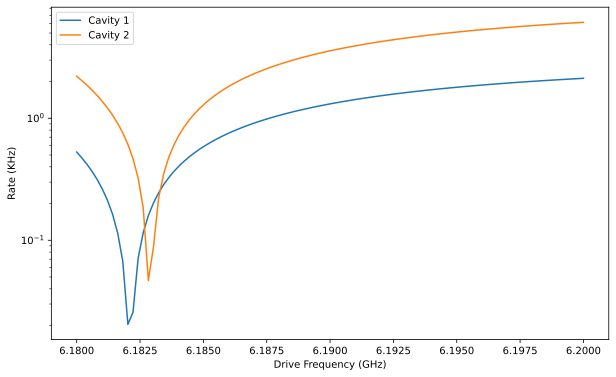

In [19]:
plt.figure(figsize=(10,6))
plt.plot(omega_ds, rates1, label='Cavity 1')
plt.plot(omega_ds, rates2, label='Cavity 2') 
plt.xlabel('Drive Frequency (GHz)')
plt.ylabel('Rate (KHz)')
plt.legend()
plt.yscale('log')
plt.show()
